# Quora Questions Deduplication

**Imports**

**Aim:** Create a baseline model in PyTorch to solve the Deduplication Task

In [1]:
import os,re,zipfile
import pandas as pd
import numpy as np
from types import SimpleNamespace
from matplotlib import pyplot as plt
import itertools
plt.style.use('dark_background')
plt.style.use('seaborn')
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.deterministic = True  

# metrics
from sklearn import metrics

# Data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

**Set PyTorch to use GPU if there is one**

In [2]:
dev = torch.device('cuda')
dev

device(type='cuda')

**Download the dataset using Kaggle credentials**

In [3]:
%%time
zip_name = 'train.csv.zip'
if not os.path.exists(zip_name):
  os.environ['KAGGLE_USERNAME'] = "" # username from the json file
  os.environ['KAGGLE_KEY'] = "" # key from the json file
  !kaggle competitions download -c quora-question-pairs

CPU times: user 238 µs, sys: 55 µs, total: 293 µs
Wall time: 227 µs


**Load data**

In [4]:
df = pd.read_csv('train.csv.zip')[['question1','question2','is_duplicate']].dropna()
dups = df[df.is_duplicate == 1].copy()
no_dups = df[df.is_duplicate == 0].copy()
split_fact = 1.3
df = pd.concat([dups[:int(len(dups) / split_fact)], no_dups[:int(len(no_dups) / split_fact)]],ignore_index=True)
df

,question1,question2,is_duplicate
0,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
1,How can I be a good geologist?,What should I do to be a great geologist?,1
2,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
3,What can make Physics easy to learn?,How can you make physics easy to learn?,1
4,What was your first sexual experience like?,What was your first sexual experience?,1
...,...,...,...
310984,How do I develop a positive attitude towards e...,How can one develop a positive attitude toward...,0
310985,How many times have sex in week?,How many times did you have sex in one day?,0
310986,"If something died in outer space, would its bo...",Are there any dead astronaut bodies floating a...,0
310987,Are American social racial issues self propaga...,Are we the direct cause of racism by constantl...,0


**Initialize a class for the USE**

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
class UniversalSentenceEncoder:

    def __init__(self, encoder='universal-sentence-encoder', version='4'):
        self.version = version
        self.encoder = encoder
        self.embd = hub.load(f"https://tfhub.dev/google/{encoder}/{version}",)

    def embed(self, sentences):
        return self.embd(sentences)

    def squized(self, sentences):
        return np.array(self.embd(tf.squeeze(tf.cast(sentences, tf.string))))

In [6]:
ue = UniversalSentenceEncoder()

**Train/Test split the data**

In [7]:
train,test = train_test_split(df,test_size=0.33,random_state=42,stratify=df['is_duplicate'])

**Convert the arrays to Tensors and specify the usage of GPU**

In [8]:
%%time
x_q1_train = torch.from_numpy(ue.squized(train['question1'].values)).type(torch.FloatTensor).to(dev)
x_q2_train = torch.from_numpy(ue.squized(train['question2'].values)).type(torch.FloatTensor).to(dev)
y_train = torch.from_numpy(train['is_duplicate'].values).type(torch.LongTensor).to(dev)

x_q1_test = torch.from_numpy(ue.squized(test['question1'].values)).type(torch.FloatTensor).to(dev)
x_q2_test = torch.from_numpy(ue.squized(test['question2'].values)).type(torch.FloatTensor).to(dev)
y_test = torch.from_numpy(test['is_duplicate'].values).type(torch.LongTensor).to(dev)

CPU times: user 1min 47s, sys: 2.95 s, total: 1min 50s
Wall time: 1min 39s


**Use the data loader to make things easier on training**

In [9]:
b_size = 256
train_dl = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_q1_train,x_q2_train,y_train), batch_size=b_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_q1_test,x_q2_test,y_test), batch_size=b_size, shuffle=True)

**Finally we do all the training in one class in the same cell for the ease of making chagnes**


Accuracy  : 66.96%
Train loss: 0.5459461212158203
Test loss : 0.6327708959579468


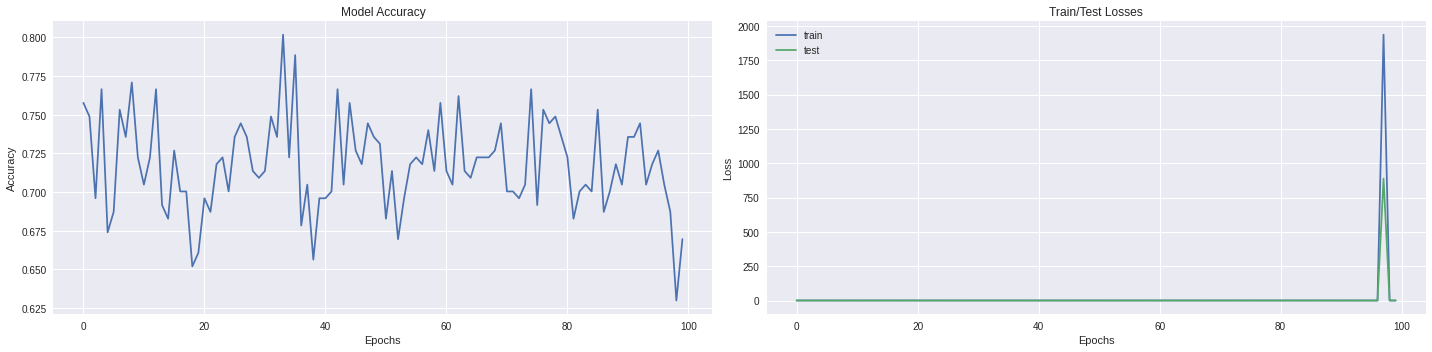

In [10]:
class Net(nn.Module):

    def __init__(self):
        super(Net,self).__init__()

        self.q1_lin = nn.Linear(in_features=512,out_features=1024)
        self.q2_lin = nn.Linear(in_features=512,out_features=1024)
        self.lin1 = nn.Linear(in_features=2048,out_features=1024)
        self.lin2 = nn.Linear(in_features=1024,out_features=512)
        self.lin3 = nn.Linear(in_features=512,out_features=256)
        self.lin4 = nn.Linear(in_features=256,out_features=128)
        self.lin5 = nn.Linear(in_features=128,out_features=2)

    # here we take the input data and pass it through the chain of layers
    def forward(self,q1,q2):
        q1 = self.q1_lin(q1)
        q2 = self.q2_lin(q2)
        x = torch.cat((q1,q2),dim=1)
        # print(x.size())
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)
        x = self.lin4(x)
        x = self.lin5(x)
        return x

# instance our model
model = Net().to(dev)
# set the number of epochs
epochs = 100
# criterion aka loss function -> find more on pytorch doc
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# create 3 lists to store the losses and accuracy at each epoch
train_losses, test_losses, accuracy = [0]*epochs, [0]*epochs,[0]*epochs


# in this current case we don't use batches for training and we pass the whole data at each epoch
for e in tqdm(range(epochs)):

    for q1,q2,label in train_dl:

        optimizer.zero_grad()
        q1 = q1.float()
        q2 = q2.float()
        # Comput train loss
        y_pred = model(q1,q2)
        loss = criterion(y_pred, label)
        
        loss.backward()

        optimizer.step()

        # store train loss
        train_losses[e] = loss.item()
    
    for q1,q2,label in test_dl:    
        # Compute the test stats
        with torch.no_grad():
            # Turn on all the nodes
            model.eval()
            q1 = q1.float()
            q2 = q2.float()
            # Comput test loss
            ps = model(q1,q2)
            loss = criterion(ps, label)

            # store test loss
            test_losses[e] = loss.item()
            
            # # Compute accuracy
            top_p, top_class = ps.topk(1, dim=1)
        
            equals = (top_class == label.view(*top_class.shape))
            
            # # store accuracy
            accuracy[e] = torch.mean(equals.type(torch.FloatTensor))

# Print the final information
print(f'Accuracy  : {100*accuracy[-1].item():0.2f}%')
print(f'Train loss: {train_losses[-1]}')
print(f'Test loss : {test_losses[-1]}')
    
# Plot the results
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Model Accuracy')
ax[0].plot(accuracy)

ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Train/Test Losses')
ax[1].plot(train_losses, label='train')
ax[1].plot(test_losses, label='test')
ax[1].legend()   

plt.tight_layout()